In [1]:
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F

# Exploring Dataset and Preprocessing

The dataset contains a total of 2872 images which have been resized to be 64 by 64. In addition images are converted to tensors and have shape [3, 64, 64]

The dataset is passed through a dataloader to sample batches from.

In [2]:
path = "gallery"
batch_size = 32
image_size = (64, 64)
mean = (0.5, 0.5, 0.5)
std = (0.5, 0.5, 0.5)
device = torch.device("cpu")
img_transforms = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    ])

dataset = torchvision.datasets.ImageFolder(root=path, transform=img_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

dataset

Dataset ImageFolder
    Number of datapoints: 2872
    Root location: gallery
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )

len(data) = 2

data[0].shape = torch.Size([32, 3, 40, 40])

data[1].shape = torch.Size([32])

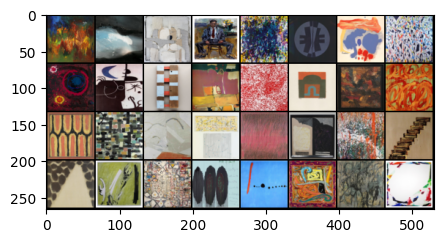

In [3]:
batch = next(iter(dataloader))
plt.figure(figsize=(5,5))
plt.imshow(np.transpose(torchvision.utils.make_grid(batch[0].to(device)).cpu(),(1,2,0)))
    

# Model and Training

## GAN Model
The [Generative Adversarial Net](https://arxiv.org/abs/1406.2661) consists of a **generative model** that aims to capture the data distribution and **discriminative model** which estimates the probability that a sample game from the dataset rather than from the generative model. 

As the generator is "generating" a RGB image with the same size and training images, then the output shape should be [3, 64, 64].

On the other hand, the discriminator is a binary classification network that outputs the scalar probability of whether the data is from the dataset or generated.

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(32, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(64 * 8, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( 64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( 64 * 2, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( 64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )
        
    def forward(self, x):
        return self.model(x)
        
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(64 * 2, 64 * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(64 * 4, 64 * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(64 * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        return self.model(x)
          
        

## Training 
Ultimately we want to update the discriminator to maximize 
$$log(D(x)) + log(1 - D(G(z)))$$

For the generator, we want to minimize 
$$log(1 - D(G(z)))$$
which is the same as maximizing
$$log(D(G(z)))$$

In [5]:
generator = Generator()
discriminator = Discriminator()
optimizerG = torch.optim.Adam(generator.parameters(), lr=1e-4)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

real_target = torch.ones(32, device=device)
fake_target = torch.zeros(batch_size, device=device)

epochs = 200
criterion = nn.BCELoss()
lossesG = []
lossesD = []
generated_images = []
fixed_noise = torch.randn(64, 32, 1, 1, device=device)

In [6]:
for i in range(epochs):
    for batch, data in enumerate(dataloader):
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
    
    # ----- train discriminator with real images ----- #
        discriminator.zero_grad()
        output = discriminator(real_cpu).view(-1)
        
        lossD_real = criterion(output, real_target)
        
    # ----- train discriminator with generated images ----- #
        noise = torch.randn(b_size, 32, 1, 1, device=device)
        generated_image = generator(noise)
        output = discriminator(generated_image.detach()).view(-1)

        lossD_fake = criterion(output, fake_target)
        
        lossD = lossD_real + lossD_fake
        lossD.backward()
        optimizerD.step()
        
    # ----- train generator ----- #
        generator.zero_grad()
        output = discriminator(generated_image).view(-1)

        lossG = criterion(output, real_target)
        lossG.backward()
        optimizerG.step()
        
        lossesD.append(lossD.item())
        lossesG.append(lossG.item())
        
        if batch % 20 == 0:
            print(f"batch: {batch}, discriminator loss: {lossD}, generator loss: {lossG}")
    
    print("======================================")
    print(f"Epoch: {i}/{epochs}, discriminator loss: {lossD}, generator loss: {lossG}")
    print("======================================\n\n")
    generated_image = generator(fixed_noise).detach().cpu()
    generated_images.append(torchvision.utils.make_grid(generated_image, padding=2, normalize=True))

batch: 0, discriminator loss: 1.4149088859558105, generator loss: 1.8933871984481812
batch: 20, discriminator loss: 0.0626857578754425, generator loss: 6.026467800140381
batch: 40, discriminator loss: 0.03233896195888519, generator loss: 7.351144790649414
batch: 60, discriminator loss: 0.013482683338224888, generator loss: 7.626928329467773
batch: 80, discriminator loss: 0.015358255244791508, generator loss: 7.995247840881348
Epoch: 0/200, discriminator loss: 0.009948568418622017, generator loss: 8.107406616210938


batch: 0, discriminator loss: 0.007768357638269663, generator loss: 8.175816535949707
batch: 20, discriminator loss: 0.005128286778926849, generator loss: 8.0966796875
batch: 40, discriminator loss: 0.008811596781015396, generator loss: 8.052945137023926
batch: 60, discriminator loss: 0.006276257801800966, generator loss: 8.876571655273438
batch: 80, discriminator loss: 0.2549601197242737, generator loss: 4.749931335449219
Epoch: 1/200, discriminator loss: 0.001792532275430

Saving Model
- 1.1.2023

In [25]:
torch.save(generator.state_dict(), 'generator')
torch.save(discriminator.state_dict(), 'discriminator')

# Results

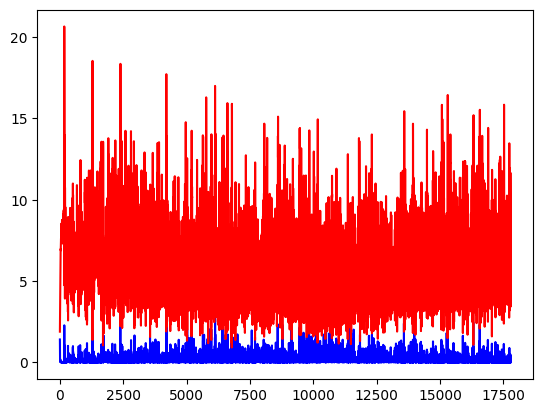

In [7]:
plt.plot(lossesD, label="Discriminator", color="blue",)
plt.plot(lossesG, label="Generator", color="red",)

At epoch 0 we observe that the model is very poor

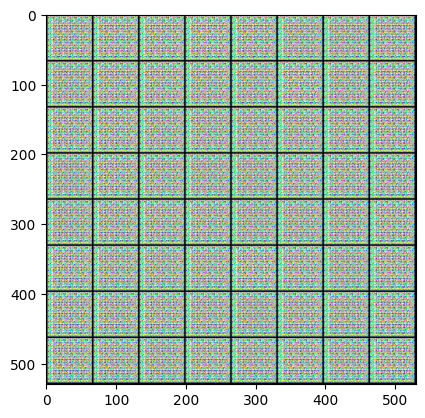

In [24]:
plt.imshow(np.transpose(generated_images[0],(1,2,0)))

The model has improved significantly at epoch 100

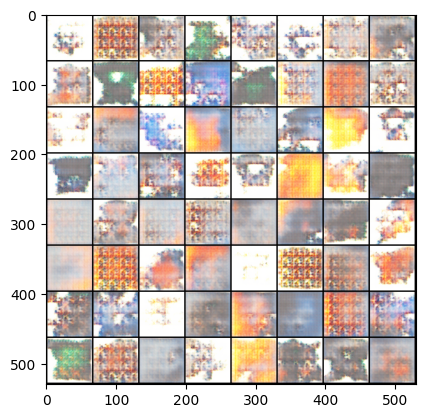

In [16]:
plt.imshow(np.transpose(generated_images[100],(1,2,0)))

At epoch 200, the model has improved slightly

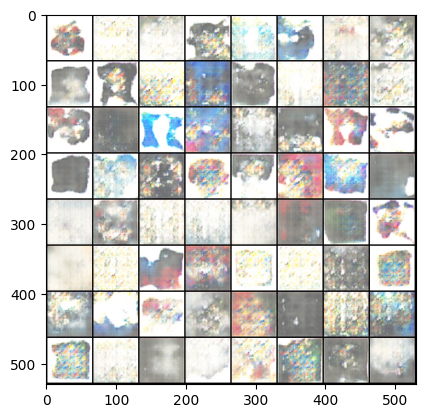

In [17]:
plt.imshow(np.transpose(generated_images[-1],(1,2,0)))

Here are the final results using the generator model

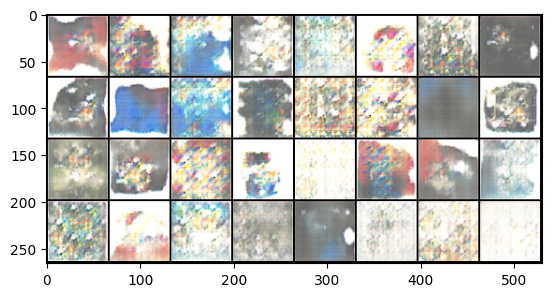

In [42]:
noise = torch.randn(b_size, 32, 1, 1, device=device)
generated_image = generator(noise)
plt.imshow(np.transpose(torchvision.utils.make_grid(generated_image, padding=2, normalize=True),(1,2,0)))